In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

from keras.models import load_model
from pathlib import Path

from ml_tb.normalisation import MinMaxScaler
from ml_tb.metrics import RMSE_denormalised_P, RMSE_denormalised_T
from ml_tb.mapping import load_biotite_map, plot_distribution, plot_map
from ml_tb.testing import get_PT_map, get_PT_analyses, get_ref_PT_analyses, PT_median, PT_error

In [2]:
# define the custom metrics
scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0)
inv_scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0, invert=True)

def RMSE_P(y_true, y_pred):
    return RMSE_denormalised_P(y_true, y_pred, inv_scaling_pt)


def RMSE_T(y_true, y_pred):
    return RMSE_denormalised_T(y_true, y_pred, inv_scaling_pt)

In [3]:
model = load_model(Path("..","03_transfer_learning", "saved_models", "03a_BtThermobarometer_finetuning"), compile=False)
model.compile(optimizer="adam", loss="mean_squared_error", metrics=[RMSE_T, RMSE_P])
# model.summary()

# Plot test dataset

In [4]:
map_files =  ["Aiyana_GrtZone_550_3500.hdf5", "Aiyana_StZone_560_3500.hdf5", "Aiyana_AndZone_580_3500.hdf5", "Aiyana_SilZone_600_3500.hdf5", "Aiyana_KfsZone_650_3500.hdf5",
              "Cioffi2001_589_3800.hdf5", "JuliaArami_700_8000.hdf5", "Lanari_Hermann_2021_Map1.hdf5", "Lanari_Hermann_2021_Map2.hdf5", "LanariDuesterhoeft2019_790_6400.hdf5",
              "LanariDuesterhoeft2020_660_7000.hdf5", "Piccoli2022_620_10000.hdf5", "XenolithElOro_750_2000.hdf5"]

test_data_file = Path("test_data_metapelitic_biotite.xlsx")
test_samples = ["Vedrette de Ries", "South Tibetian Detachment", "Longmen Shan 13-4 Core", "Longmen Shan 13-4 Rim", "Longmen Shan 13-7 Core",
                "Longmen Shan 13-7 Rim", "Seve Nappe", "Kluane_Cord_1", "Kluane_Cord_2", "Kluane_AndSil",
                "Kluane_Migmatite", "Kluane_Grt", "GDB Hop Brook 1", "GDB Waterbury", "GDB Straits Schist 1",
                "GDB Taine Mountain 1", "GDB Collinsville", "GDB Straits Schist 2", "GDB Straits Schist 3", "GDB Taine Mountain 2",
                "GDB Hop Brook 2", "Leech river AG080", "Leech river AG042", "Leech river AG067", "Leech river AG1161",
                "Suru Valley Grt Zone 1", "Suru Valley Grt Zone 2", "Suru Valley Stau Zone 1", "Suru Valley Stau Zone 2", "Suru Valley Ky Zone 1",
                "Suru Valley Ky Zone 2", "Suru Valley Sil Zone 1", "Suru Valley Sil Zone 2", "Suru Valley Kfs Zone 1", "Suru Valley Kfs Zone 2"]

PT_ref = []
# add in reference PT manually, for the Maps
PT_ref_maps = [[3500, 550], [3500, 560], [3500, 580], [3500, 600], [3500, 650],
               [3800, 589], [8000, 700], [9000, 620], [9000, 620], [6400, 790],
               [7000, 660], [10000, 620], [2000, 750]]
for PT in PT_ref_maps:
    PT_ref.append(PT)

PT_predictions = []
PT_errors = []

for map_file in map_files:
    PT_map = get_PT_map(Path("..", "05b_maps", "XMapTools_map_files") / map_file, model, inv_scaling_pt)
    PT_predictions.append(PT_median(PT_map))
    PT_errors.append(PT_error(PT_map))

for test_id in test_samples:
    PT_multi_analyses = get_PT_analyses(test_data_file, test_id, model, inv_scaling_pt)
    PT_predictions.append(PT_median(PT_multi_analyses))
    PT_errors.append(PT_error(PT_multi_analyses))

    # add ref PT
    PT_ref.append(get_ref_PT_analyses(test_data_file, test_id))

PT_predictions = np.array(PT_predictions)
PT_errors = np.array(PT_errors)

PT_ref = np.array(PT_ref)

In [5]:
rmse_T = np.sqrt(np.mean(np.square(PT_ref[:, 1] - PT_predictions[:, 1])))
rmse_P = np.sqrt(np.mean(np.square(PT_ref[:, 0] - PT_predictions[:, 0])))

print("RMSE T [C] {0:.2f}".format(rmse_T))
print("RMSE P [bar] {0:.2f}".format(rmse_P))

RMSE T [C] 44.88
RMSE P [bar] 3712.52


In [6]:
mae_T = np.mean(abs(PT_ref[:, 1] - PT_predictions[:, 1]))
mae_P = np.mean(abs(PT_ref[:, 0] - PT_predictions[:, 0]))

print("MAE T [C] {0:.2f}".format(mae_T))
print("MAE P [bar] {0:.2f}".format(mae_P))

MAE T [C] 33.50
MAE P [bar] 2822.28


In [7]:
markers = ["o", "o", "o", "o", "o",
           "o", "o", "o", "o", "o",
           "o", "o", "o",
           "s", "s", "s", "s", "s",
           "s",
           "^", "^", "^", "^", "^",
           "^", "^", "^", "^", "^",
           "^", "^", "^", "^", "^",
           "^", "^", "^", "^", "^",
           "^", "^", "^", "^", "^",
           "^", "^", "^", "^"]

colors = ["firebrick", "firebrick", "firebrick", "firebrick", "firebrick",
           "firebrick", "firebrick", "firebrick", "firebrick", "firebrick",
           "firebrick", "firebrick", "firebrick",
           "olivedrab", "olivedrab", "olivedrab", "olivedrab", "olivedrab",
           "olivedrab",
           "steelblue", "steelblue", "steelblue", "steelblue", "steelblue",
           "steelblue", "steelblue", "steelblue", "steelblue", "steelblue",
           "steelblue", "steelblue", "steelblue", "steelblue", "steelblue",
           "steelblue", "steelblue", "steelblue", "steelblue", "steelblue",
           "steelblue", "steelblue", "steelblue", "steelblue", "steelblue",
           "steelblue", "steelblue", "steelblue", "steelblue"]

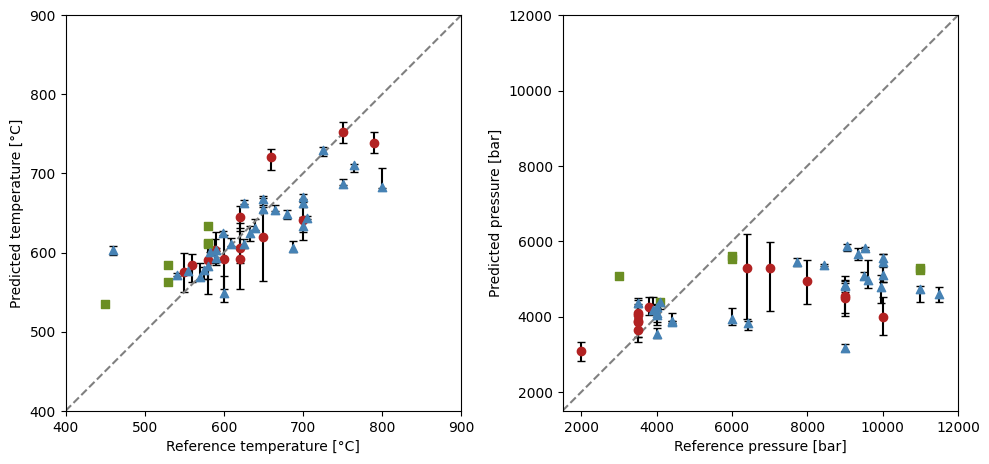

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

axs[0].errorbar(PT_ref[:, 1], PT_predictions[:, 1], yerr=PT_errors[:, 1, 0].T, fmt="None", capsize=3, color="black")
for i, marker in enumerate(markers):
    axs[0].scatter(PT_ref[i, 1], PT_predictions[i, 1], marker=marker, c=colors[i], zorder=3)

axs[0].plot([400, 900], [400, 900], "--", color="gray")

axs[0].set_xlabel("Reference temperature [°C]")
axs[0].set_ylabel("Predicted temperature [°C]")
axs[0].set_xlim([400, 900])
axs[0].set_ylim([400, 900])
axs[0].set_aspect("equal")

axs[1].errorbar(PT_ref[:, 0], PT_predictions[:, 0], yerr=PT_errors[:, 0, 0].T, fmt="None", capsize=3, color="black")
for i, marker in enumerate(markers):
    axs[1].scatter(PT_ref[i, 0], PT_predictions[i, 0], marker=marker, c=colors[i], zorder=3)

axs[1].plot([1500, 12000], [1500, 12000], "--", color="gray")

axs[1].set_xlabel("Reference pressure [bar]")
axs[1].set_ylabel("Predicted pressure [bar]")
axs[1].set_xlim([1500, 12000])
axs[1].set_ylim([1500, 12000])
axs[1].set_aspect("equal")

fig.tight_layout()
# fig.savefig(Path("exported_figs", "PT_pred_vs_ref.pdf"), dpi=600)

# Plot only the test datapoints of the compositional maps

In [9]:
map_files =  ["Aiyana_GrtZone_550_3500.hdf5", "Aiyana_StZone_560_3500.hdf5", "Aiyana_AndZone_580_3500.hdf5", "Aiyana_SilZone_600_3500.hdf5", "Aiyana_KfsZone_650_3500.hdf5",
              "Cioffi2001_589_3800.hdf5", "JuliaArami_700_8000.hdf5", "Lanari_Hermann_2021_Map1.hdf5", "Lanari_Hermann_2021_Map2.hdf5", "LanariDuesterhoeft2019_790_6400.hdf5",
              "LanariDuesterhoeft2020_660_7000.hdf5", "Piccoli2022_620_10000.hdf5", "XenolithElOro_750_2000.hdf5"]

PT_ref = []
# add in reference PT manually, for the Maps
PT_ref_maps = [[3500, 550], [3500, 560], [3500, 580], [3500, 600], [3500, 650],
               [3800, 589], [8000, 700], [9000, 620], [9000, 620], [6400, 790],
               [7000, 660], [10000, 620], [2000, 750]]
for PT in PT_ref_maps:
    PT_ref.append(PT)

PT_predictions = []
PT_errors = []

for map_file in map_files:
    PT_map = get_PT_map(Path("..", "05b_maps", "XMapTools_map_files") / map_file, model, inv_scaling_pt)
    PT_predictions.append(PT_median(PT_map))
    PT_errors.append(PT_error(PT_map))


PT_predictions = np.array(PT_predictions)
PT_errors = np.array(PT_errors)

PT_ref = np.array(PT_ref)

In [10]:
rmse_T = np.sqrt(np.mean(np.square(PT_ref[:, 1] - PT_predictions[:, 1])))
rmse_P = np.sqrt(np.mean(np.square(PT_ref[:, 0] - PT_predictions[:, 0])))

print("RMSE T [C] {0:.2f}".format(rmse_T))
print("RMSE P [bar] {0:.2f}".format(rmse_P))

RMSE T [C] 32.59
RMSE P [bar] 2662.71


In [11]:
mae_T = np.mean(abs(PT_ref[:, 1] - PT_predictions[:, 1]))
mae_P = np.mean(abs(PT_ref[:, 0] - PT_predictions[:, 0]))

print("MAE T [C] {0:.2f}".format(mae_T))
print("MAE P [bar] {0:.2f}".format(mae_P))

MAE T [C] 27.03
MAE P [bar] 1876.01


In [12]:
labels =  ["Aiyana_GrtZone_550_3500.hdf5", "Aiyana_StZone_560_3500.hdf5", "Aiyana_AndZone_580_3500.hdf5", "Aiyana_SilZone_600_3500.hdf5", "Aiyana_KfsZone_650_3500.hdf5",
              "Cioffi2001_589_3800.hdf5", "JuliaArami_700_8000.hdf5", "Lanari_Hermann_2021_Map1.hdf5", "Lanari_Hermann_2021_Map2.hdf5", "LanariDuesterhoeft2019_790_6400.hdf5",
              "LanariDuesterhoeft2020_660_7000.hdf5", "Piccoli2022_620_10000.hdf5", "XenolithElOro_750_2000.hdf5"]

/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_39628/2895536192.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0].scatter(PT_ref[i, 1], PT_predictions[i, 1], marker="o", c=color, zorder=3)
/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_39628/2895536192.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1].scatter(PT_ref[i, 0], PT_predictions[i, 0], marker="o", c=color, label=labels[i], 

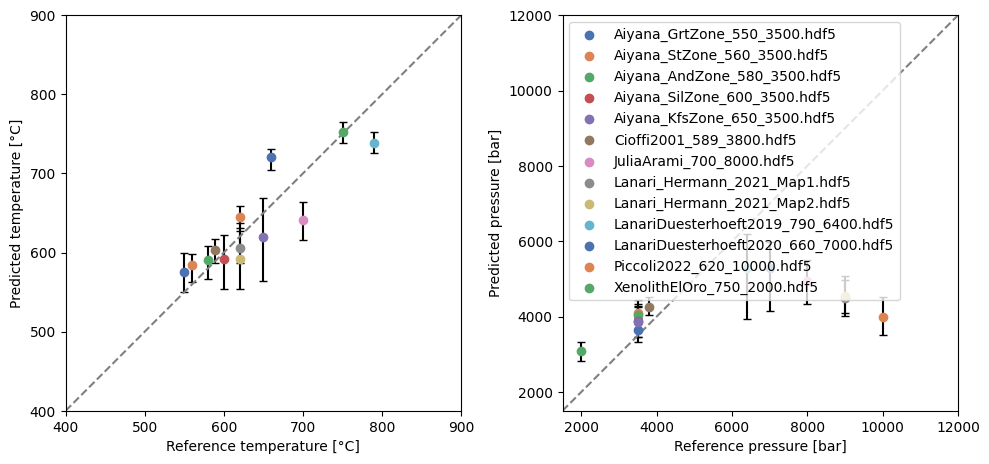

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

axs[0].errorbar(PT_ref[:, 1], PT_predictions[:, 1], yerr=PT_errors[:, 1, 0].T, fmt="None", capsize=3, color="black")
for i, color in enumerate(sns.color_palette("deep", len(map_files))):
    axs[0].scatter(PT_ref[i, 1], PT_predictions[i, 1], marker="o", c=color, zorder=3)

axs[0].plot([400, 900], [400, 900], "--", color="gray")

axs[0].set_xlabel("Reference temperature [°C]")
axs[0].set_ylabel("Predicted temperature [°C]")
axs[0].set_xlim([400, 900])
axs[0].set_ylim([400, 900])
axs[0].set_aspect("equal")

axs[1].errorbar(PT_ref[:, 0], PT_predictions[:, 0], yerr=PT_errors[:, 0, 0].T, fmt="None", capsize=3, color="black")
for i, color in enumerate(sns.color_palette("deep", len(map_files))):
    axs[1].scatter(PT_ref[i, 0], PT_predictions[i, 0], marker="o", c=color, label=labels[i], zorder=3)

axs[1].plot([1500, 12000], [1500, 12000], "--", color="gray")

axs[1].set_xlabel("Reference pressure [bar]")
axs[1].set_ylabel("Predicted pressure [bar]")
axs[1].set_xlim([1500, 12000])
axs[1].set_ylim([1500, 12000])
axs[1].set_aspect("equal")

axs[1].legend(loc="upper left")

fig.tight_layout()

# Plot the test dataset of the literature dataset

In [14]:
test_data_file = Path("test_data_metapelitic_biotite.xlsx")
test_samples = ["Vedrette de Ries", "South Tibetian Detachment", "Longmen Shan 13-4 Core", "Longmen Shan 13-4 Rim", "Longmen Shan 13-7 Core",
                "Longmen Shan 13-7 Rim", "Seve Nappe", "Kluane_Cord_1", "Kluane_Cord_2", "Kluane_AndSil",
                "Kluane_Migmatite", "Kluane_Grt", "GDB Hop Brook 1", "GDB Waterbury", "GDB Straits Schist 1",
                "GDB Taine Mountain 1", "GDB Collinsville", "GDB Straits Schist 2", "GDB Straits Schist 3", "GDB Taine Mountain 2",
                "GDB Hop Brook 2", "Leech river AG080", "Leech river AG042", "Leech river AG067", "Leech river AG1161",
                "Suru Valley Grt Zone 1", "Suru Valley Grt Zone 2", "Suru Valley Stau Zone 1", "Suru Valley Stau Zone 2", "Suru Valley Ky Zone 1",
                "Suru Valley Ky Zone 2", "Suru Valley Sil Zone 1", "Suru Valley Sil Zone 2", "Suru Valley Kfs Zone 1", "Suru Valley Kfs Zone 2"]

PT_ref = []

PT_predictions = []
PT_errors = []

for test_id in test_samples:
    PT_multi_analyses = get_PT_analyses(test_data_file, test_id, model, inv_scaling_pt)
    PT_predictions.append(PT_median(PT_multi_analyses))
    PT_errors.append(PT_error(PT_multi_analyses))

    # add ref PT
    PT_ref.append(get_ref_PT_analyses(test_data_file, test_id))

PT_predictions = np.array(PT_predictions)
PT_errors = np.array(PT_errors)

PT_ref = np.array(PT_ref)

In [15]:
rmse_T = np.sqrt(np.mean(np.square(PT_ref[:, 1] - PT_predictions[:, 1])))
rmse_P = np.sqrt(np.mean(np.square(PT_ref[:, 0] - PT_predictions[:, 0])))

print("RMSE T [C] {0:.2f}".format(rmse_T))
print("RMSE P [bar] {0:.2f}".format(rmse_P))

RMSE T [C] 48.66
RMSE P [bar] 4033.45


In [16]:
mae_T = np.mean(abs(PT_ref[:, 1] - PT_predictions[:, 1]))
mae_P = np.mean(abs(PT_ref[:, 0] - PT_predictions[:, 0]))

print("MAE T [C] {0:.2f}".format(mae_T))
print("MAE P [bar] {0:.2f}".format(mae_P))

MAE T [C] 35.90
MAE P [bar] 3173.75


In [17]:
labels = ["Vedrette de Ries", "South Tibetian Detachment", "Longmen Shan 13-4 Core", "Longmen Shan 13-4 Rim", "Longmen Shan 13-7 Core",
                "Longmen Shan 13-7 Rim", "Seve Nappe", "Kluane_Cord_1", "Kluane_Cord_2", "Kluane_AndSil",
                "Kluane_Migmatite", "Kluane_Grt", "GDB Hop Brook 1", "GDB Waterbury", "GDB Straits Schist 1",
                "GDB Taine Mountain 1", "GDB Collinsville", "GDB Straits Schist 2", "GDB Straits Schist 3", "GDB Taine Mountain 2",
                "GDB Hop Brook 2", "Leech river AG080", "Leech river AG042", "Leech river AG067", "Leech river AG1161",
                "Suru Valley Grt Zone 1", "Suru Valley Grt Zone 2", "Suru Valley Stau Zone 1", "Suru Valley Stau Zone 2", "Suru Valley Ky Zone 1",
                "Suru Valley Ky Zone 2", "Suru Valley Sil Zone 1", "Suru Valley Sil Zone 2", "Suru Valley Kfs Zone 1", "Suru Valley Kfs Zone 2"]

/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_39628/621586773.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0].scatter(PT_ref[i, 1], PT_predictions[i, 1], marker="o", c=color, zorder=3)
/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_39628/621586773.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1].scatter(PT_ref[i, 0], PT_predictions[i, 0], marker="o", c=color, label=labels[i], zo

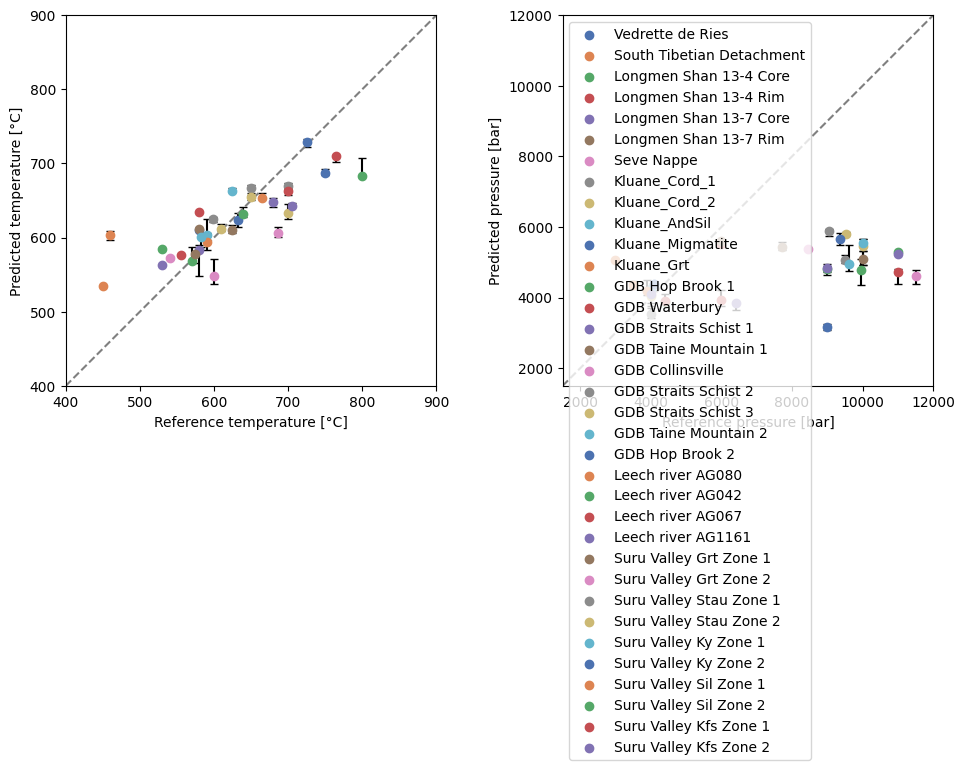

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

axs[0].errorbar(PT_ref[:, 1], PT_predictions[:, 1], yerr=PT_errors[:, 1, 0].T, fmt="None", capsize=3, color="black")
for i, color in enumerate(sns.color_palette("deep", len(test_samples))):
    axs[0].scatter(PT_ref[i, 1], PT_predictions[i, 1], marker="o", c=color, zorder=3)

axs[0].plot([400, 900], [400, 900], "--", color="gray")

axs[0].set_xlabel("Reference temperature [°C]")
axs[0].set_ylabel("Predicted temperature [°C]")
axs[0].set_xlim([400, 900])
axs[0].set_ylim([400, 900])
axs[0].set_aspect("equal")

axs[1].errorbar(PT_ref[:, 0], PT_predictions[:, 0], yerr=PT_errors[:, 0, 0].T, fmt="None", capsize=3, color="black")
for i, color in enumerate(sns.color_palette("deep", len(test_samples))):
    axs[1].scatter(PT_ref[i, 0], PT_predictions[i, 0], marker="o", c=color, label=labels[i], zorder=3)

axs[1].plot([1500, 12000], [1500, 12000], "--", color="gray")

axs[1].set_xlabel("Reference pressure [bar]")
axs[1].set_ylabel("Predicted pressure [bar]")
axs[1].set_xlim([1500, 12000])
axs[1].set_ylim([1500, 12000])
axs[1].set_aspect("equal")

axs[1].legend(loc="upper left")

fig.tight_layout()

In [19]:
test_data_file = Path("test_data_metapelitic_biotite.xlsx")
test_samples = ["Vedrette de Ries", "South Tibetian Detachment", "Longmen Shan 13-4 Core", "Longmen Shan 13-4 Rim", "Longmen Shan 13-7 Core",
                "Longmen Shan 13-7 Rim", "Seve Nappe"]

PT_ref = []

PT_predictions = []
PT_errors = []

for test_id in test_samples:
    PT_multi_analyses = get_PT_analyses(test_data_file, test_id, model, inv_scaling_pt)
    PT_predictions.append(PT_median(PT_multi_analyses))
    PT_errors.append(PT_error(PT_multi_analyses))

    # add ref PT
    PT_ref.append(get_ref_PT_analyses(test_data_file, test_id))

PT_predictions = np.array(PT_predictions)
PT_errors = np.array(PT_errors)

PT_ref = np.array(PT_ref)

In [20]:
labels = ["Vedrette de Ries", "South Tibetian Detachment", "Longmen Shan 13-4 Core", "Longmen Shan 13-4 Rim", "Longmen Shan 13-7 Core",
                "Longmen Shan 13-7 Rim", "Seve Nappe"]

/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_39628/1985287536.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0].scatter(PT_ref[i, 1], PT_predictions[i, 1], marker="o", c=color, zorder=3)
/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_39628/1985287536.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1].scatter(PT_ref[i, 0], PT_predictions[i, 0], marker="o", c=color, label=labels[i], 

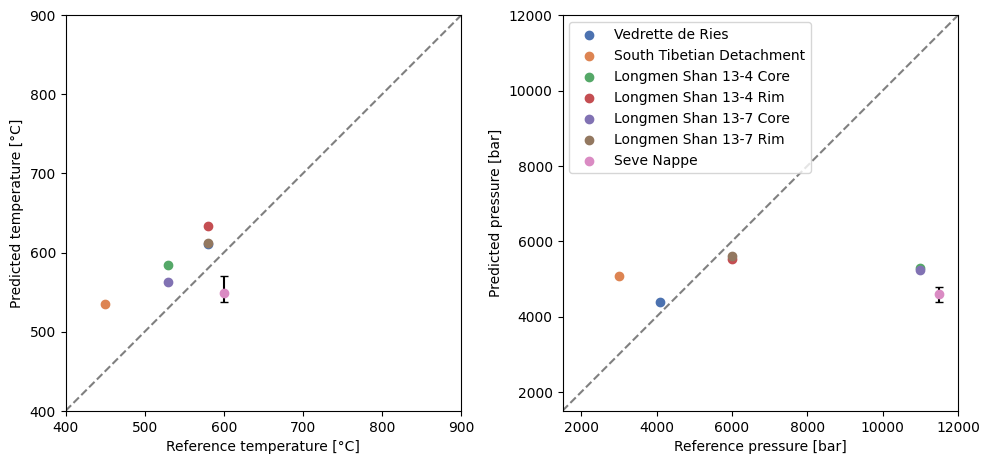

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

axs[0].errorbar(PT_ref[:, 1], PT_predictions[:, 1], yerr=PT_errors[:, 1, 0].T, fmt="None", capsize=3, color="black")
for i, color in enumerate(sns.color_palette("deep", len(labels))):
    axs[0].scatter(PT_ref[i, 1], PT_predictions[i, 1], marker="o", c=color, zorder=3)

axs[0].plot([400, 900], [400, 900], "--", color="gray")

axs[0].set_xlabel("Reference temperature [°C]")
axs[0].set_ylabel("Predicted temperature [°C]")
axs[0].set_xlim([400, 900])
axs[0].set_ylim([400, 900])
axs[0].set_aspect("equal")

axs[1].errorbar(PT_ref[:, 0], PT_predictions[:, 0], yerr=PT_errors[:, 0, 0].T, fmt="None", capsize=3, color="black")
for i, color in enumerate(sns.color_palette("deep", len(labels))):
    axs[1].scatter(PT_ref[i, 0], PT_predictions[i, 0], marker="o", c=color, label=labels[i], zorder=3)

axs[1].plot([1500, 12000], [1500, 12000], "--", color="gray")

axs[1].set_xlabel("Reference pressure [bar]")
axs[1].set_ylabel("Predicted pressure [bar]")
axs[1].set_xlim([1500, 12000])
axs[1].set_ylim([1500, 12000])
axs[1].set_aspect("equal")

axs[1].legend(loc="upper left")

fig.tight_layout()

In [22]:
test_data_file = Path("test_data_metapelitic_biotite.xlsx")
test_samples = ["Kluane_Cord_1", "Kluane_Cord_2", "Kluane_AndSil", "Kluane_Migmatite", "Kluane_Grt"]

PT_ref = []

PT_predictions = []
PT_errors = []

for test_id in test_samples:
    PT_multi_analyses = get_PT_analyses(test_data_file, test_id, model, inv_scaling_pt)
    PT_predictions.append(PT_median(PT_multi_analyses))
    PT_errors.append(PT_error(PT_multi_analyses))

    # add ref PT
    PT_ref.append(get_ref_PT_analyses(test_data_file, test_id))

PT_predictions = np.array(PT_predictions)
PT_errors = np.array(PT_errors)

PT_ref = np.array(PT_ref)

In [23]:
labels = ["Kluane_Cord_1", "Kluane_Cord_2", "Kluane_AndSil", "Kluane_Migmatite", "Kluane_Grt"]

/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_39628/1985287536.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0].scatter(PT_ref[i, 1], PT_predictions[i, 1], marker="o", c=color, zorder=3)
/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_39628/1985287536.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1].scatter(PT_ref[i, 0], PT_predictions[i, 0], marker="o", c=color, label=labels[i], 

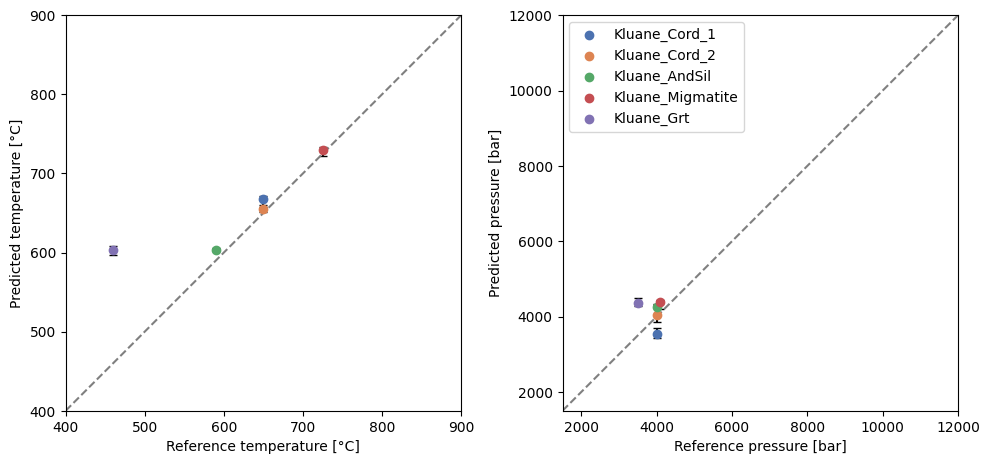

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

axs[0].errorbar(PT_ref[:, 1], PT_predictions[:, 1], yerr=PT_errors[:, 1, 0].T, fmt="None", capsize=3, color="black")
for i, color in enumerate(sns.color_palette("deep", len(labels))):
    axs[0].scatter(PT_ref[i, 1], PT_predictions[i, 1], marker="o", c=color, zorder=3)

axs[0].plot([400, 900], [400, 900], "--", color="gray")

axs[0].set_xlabel("Reference temperature [°C]")
axs[0].set_ylabel("Predicted temperature [°C]")
axs[0].set_xlim([400, 900])
axs[0].set_ylim([400, 900])
axs[0].set_aspect("equal")

axs[1].errorbar(PT_ref[:, 0], PT_predictions[:, 0], yerr=PT_errors[:, 0, 0].T, fmt="None", capsize=3, color="black")
for i, color in enumerate(sns.color_palette("deep", len(labels))):
    axs[1].scatter(PT_ref[i, 0], PT_predictions[i, 0], marker="o", c=color, label=labels[i], zorder=3)

axs[1].plot([1500, 12000], [1500, 12000], "--", color="gray")

axs[1].set_xlabel("Reference pressure [bar]")
axs[1].set_ylabel("Predicted pressure [bar]")
axs[1].set_xlim([1500, 12000])
axs[1].set_ylim([1500, 12000])
axs[1].set_aspect("equal")

axs[1].legend(loc="upper left")

fig.tight_layout()

In [25]:
test_data_file = Path("test_data_metapelitic_biotite.xlsx")
test_samples = ["GDB Hop Brook 1", "GDB Waterbury", "GDB Straits Schist 1",
                "GDB Taine Mountain 1", "GDB Collinsville", "GDB Straits Schist 2", "GDB Straits Schist 3", "GDB Taine Mountain 2",
                "GDB Hop Brook 2"]

PT_ref = []

PT_predictions = []
PT_errors = []

for test_id in test_samples:
    PT_multi_analyses = get_PT_analyses(test_data_file, test_id, model, inv_scaling_pt)
    PT_predictions.append(PT_median(PT_multi_analyses))
    PT_errors.append(PT_error(PT_multi_analyses))

    # add ref PT
    PT_ref.append(get_ref_PT_analyses(test_data_file, test_id))

PT_predictions = np.array(PT_predictions)
PT_errors = np.array(PT_errors)

PT_ref = np.array(PT_ref)

In [26]:
labels = ["GDB Hop Brook 1", "GDB Waterbury", "GDB Straits Schist 1", "GDB Taine Mountain 1", "GDB Collinsville", "GDB Straits Schist 2", "GDB Straits Schist 3", "GDB Taine Mountain 2", "GDB Hop Brook 2"]

/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_39628/1985287536.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0].scatter(PT_ref[i, 1], PT_predictions[i, 1], marker="o", c=color, zorder=3)
/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_39628/1985287536.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1].scatter(PT_ref[i, 0], PT_predictions[i, 0], marker="o", c=color, label=labels[i], 

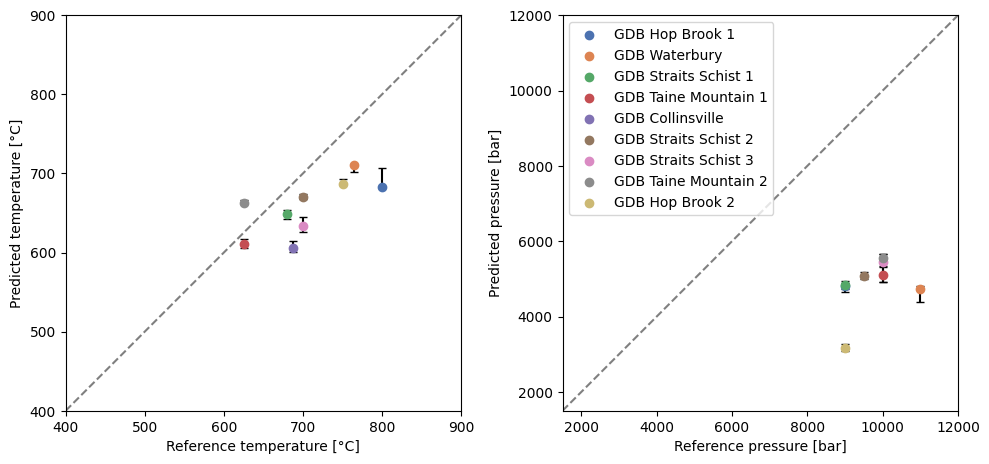

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

axs[0].errorbar(PT_ref[:, 1], PT_predictions[:, 1], yerr=PT_errors[:, 1, 0].T, fmt="None", capsize=3, color="black")
for i, color in enumerate(sns.color_palette("deep", len(labels))):
    axs[0].scatter(PT_ref[i, 1], PT_predictions[i, 1], marker="o", c=color, zorder=3)

axs[0].plot([400, 900], [400, 900], "--", color="gray")

axs[0].set_xlabel("Reference temperature [°C]")
axs[0].set_ylabel("Predicted temperature [°C]")
axs[0].set_xlim([400, 900])
axs[0].set_ylim([400, 900])
axs[0].set_aspect("equal")

axs[1].errorbar(PT_ref[:, 0], PT_predictions[:, 0], yerr=PT_errors[:, 0, 0].T, fmt="None", capsize=3, color="black")
for i, color in enumerate(sns.color_palette("deep", len(labels))):
    axs[1].scatter(PT_ref[i, 0], PT_predictions[i, 0], marker="o", c=color, label=labels[i], zorder=3)

axs[1].plot([1500, 12000], [1500, 12000], "--", color="gray")

axs[1].set_xlabel("Reference pressure [bar]")
axs[1].set_ylabel("Predicted pressure [bar]")
axs[1].set_xlim([1500, 12000])
axs[1].set_ylim([1500, 12000])
axs[1].set_aspect("equal")

axs[1].legend(loc="upper left")

fig.tight_layout()

In [28]:
test_data_file = Path("test_data_metapelitic_biotite.xlsx")
test_samples = ["Leech river AG080", "Leech river AG042", "Leech river AG067", "Leech river AG1161"]

PT_ref = []

PT_predictions = []
PT_errors = []

for test_id in test_samples:
    PT_multi_analyses = get_PT_analyses(test_data_file, test_id, model, inv_scaling_pt)
    PT_predictions.append(PT_median(PT_multi_analyses))
    PT_errors.append(PT_error(PT_multi_analyses))

    # add ref PT
    PT_ref.append(get_ref_PT_analyses(test_data_file, test_id))

PT_predictions = np.array(PT_predictions)
PT_errors = np.array(PT_errors)

PT_ref = np.array(PT_ref)

In [29]:
labels = ["Leech river AG080", "Leech river AG042", "Leech river AG067", "Leech river AG1161"]

/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_39628/1985287536.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0].scatter(PT_ref[i, 1], PT_predictions[i, 1], marker="o", c=color, zorder=3)
/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_39628/1985287536.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1].scatter(PT_ref[i, 0], PT_predictions[i, 0], marker="o", c=color, label=labels[i], 

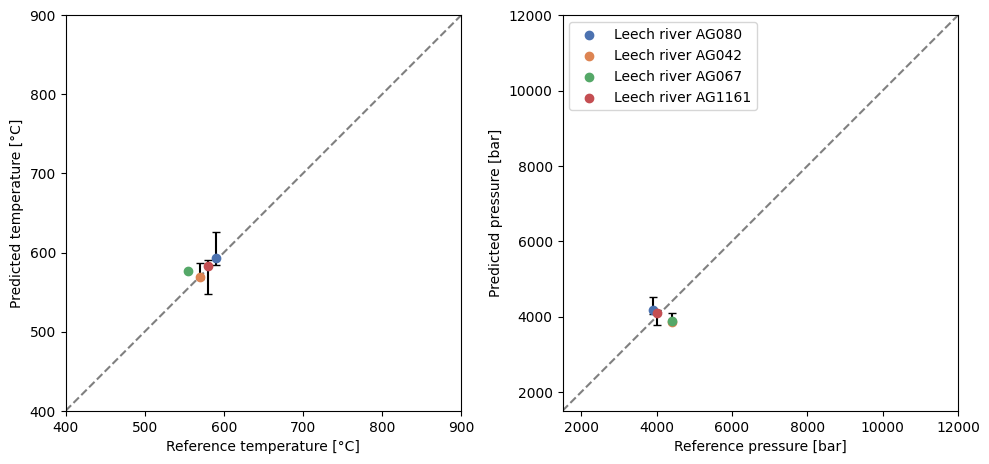

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

axs[0].errorbar(PT_ref[:, 1], PT_predictions[:, 1], yerr=PT_errors[:, 1, 0].T, fmt="None", capsize=3, color="black")
for i, color in enumerate(sns.color_palette("deep", len(labels))):
    axs[0].scatter(PT_ref[i, 1], PT_predictions[i, 1], marker="o", c=color, zorder=3)

axs[0].plot([400, 900], [400, 900], "--", color="gray")

axs[0].set_xlabel("Reference temperature [°C]")
axs[0].set_ylabel("Predicted temperature [°C]")
axs[0].set_xlim([400, 900])
axs[0].set_ylim([400, 900])
axs[0].set_aspect("equal")

axs[1].errorbar(PT_ref[:, 0], PT_predictions[:, 0], yerr=PT_errors[:, 0, 0].T, fmt="None", capsize=3, color="black")
for i, color in enumerate(sns.color_palette("deep", len(labels))):
    axs[1].scatter(PT_ref[i, 0], PT_predictions[i, 0], marker="o", c=color, label=labels[i], zorder=3)

axs[1].plot([1500, 12000], [1500, 12000], "--", color="gray")

axs[1].set_xlabel("Reference pressure [bar]")
axs[1].set_ylabel("Predicted pressure [bar]")
axs[1].set_xlim([1500, 12000])
axs[1].set_ylim([1500, 12000])
axs[1].set_aspect("equal")

axs[1].legend(loc="upper left")

fig.tight_layout()

In [31]:
test_data_file = Path("test_data_metapelitic_biotite.xlsx")
test_samples = ["Suru Valley Grt Zone 1", "Suru Valley Grt Zone 2", "Suru Valley Stau Zone 1", "Suru Valley Stau Zone 2", "Suru Valley Ky Zone 1",
                "Suru Valley Ky Zone 2", "Suru Valley Sil Zone 1", "Suru Valley Sil Zone 2", "Suru Valley Kfs Zone 1", "Suru Valley Kfs Zone 2"]

PT_ref = []

PT_predictions = []
PT_errors = []

for test_id in test_samples:
    PT_multi_analyses = get_PT_analyses(test_data_file, test_id, model, inv_scaling_pt)
    PT_predictions.append(PT_median(PT_multi_analyses))
    PT_errors.append(PT_error(PT_multi_analyses))

    # add ref PT
    PT_ref.append(get_ref_PT_analyses(test_data_file, test_id))

PT_predictions = np.array(PT_predictions)
PT_errors = np.array(PT_errors)

PT_ref = np.array(PT_ref)

In [32]:
labels = ["Suru Valley Grt Zone 1", "Suru Valley Grt Zone 2", "Suru Valley Stau Zone 1", "Suru Valley Stau Zone 2", "Suru Valley Ky Zone 1",
          "Suru Valley Ky Zone 2", "Suru Valley Sil Zone 1", "Suru Valley Sil Zone 2", "Suru Valley Kfs Zone 1", "Suru Valley Kfs Zone 2"]

/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_39628/1985287536.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0].scatter(PT_ref[i, 1], PT_predictions[i, 1], marker="o", c=color, zorder=3)
/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_39628/1985287536.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1].scatter(PT_ref[i, 0], PT_predictions[i, 0], marker="o", c=color, label=labels[i], 

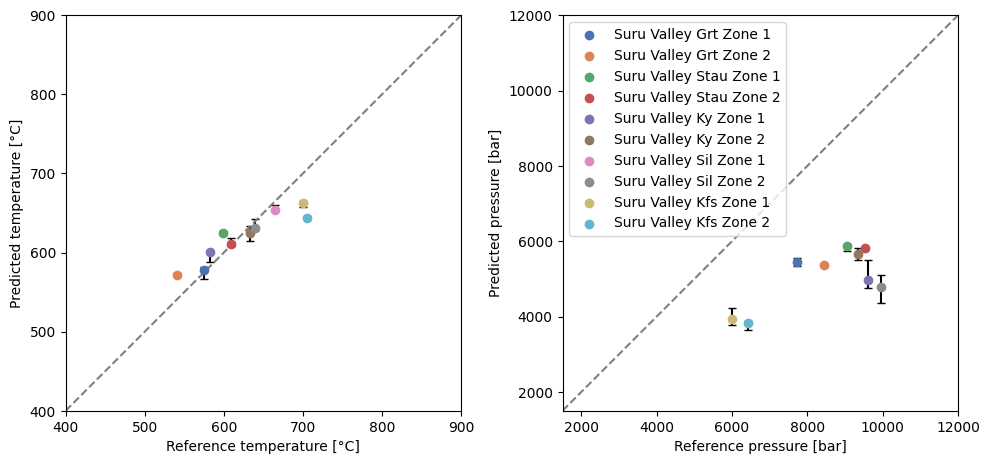

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

axs[0].errorbar(PT_ref[:, 1], PT_predictions[:, 1], yerr=PT_errors[:, 1, 0].T, fmt="None", capsize=3, color="black")
for i, color in enumerate(sns.color_palette("deep", len(labels))):
    axs[0].scatter(PT_ref[i, 1], PT_predictions[i, 1], marker="o", c=color, zorder=3)

axs[0].plot([400, 900], [400, 900], "--", color="gray")

axs[0].set_xlabel("Reference temperature [°C]")
axs[0].set_ylabel("Predicted temperature [°C]")
axs[0].set_xlim([400, 900])
axs[0].set_ylim([400, 900])
axs[0].set_aspect("equal")

axs[1].errorbar(PT_ref[:, 0], PT_predictions[:, 0], yerr=PT_errors[:, 0, 0].T, fmt="None", capsize=3, color="black")
for i, color in enumerate(sns.color_palette("deep", len(labels))):
    axs[1].scatter(PT_ref[i, 0], PT_predictions[i, 0], marker="o", c=color, label=labels[i], zorder=3)

axs[1].plot([1500, 12000], [1500, 12000], "--", color="gray")

axs[1].set_xlabel("Reference pressure [bar]")
axs[1].set_ylabel("Predicted pressure [bar]")
axs[1].set_xlim([1500, 12000])
axs[1].set_ylim([1500, 12000])
axs[1].set_aspect("equal")

axs[1].legend(loc="upper left")

fig.tight_layout()